# Exploratory Data Analysis Stage One: App Performance Overview
Stage one of our exploratory data analysis aims to expose patterns and yield insight into the nature and intensity of the customer experience within the IOS app user community. 

## The Dataset
The dataset contains the following product descriptive, rating, price, and developer data for some 475,132 apps from the App Store. 

| #  | Variable                | Date Type  | Description                                |
|----|-------------------------|------------|--------------------------------------------|
| 1  | id                      | Nominal    | App Id from the App Store                  |
| 2  | name                    | Nominal    | App Name                                   |
| 3  | description             | Nominal    | App Description                            |
| 4  | category_id             | Nominal | Numeric category identifier                |
| 5  | category                | Nominal    | Category name                              |
| 6  | price                   | Continuous | App Price                                  |
| 7  | developer_id            | Nominal    | Identifier for the developer               |
| 8  | developer               | Nominal    | Name of the developer                      |
| 9  | rating                  | Ordinal   | Average user rating since first released   |
| 10 | ratings                 | Discrete   | Number of ratings since first release      |
| 11 | released                | Continuous   | Datetime of first release                  |

## EDA Approach
Our exploration will comprise the following five analyses.

1. Structural Analysis: Examine the overall shape, structure, and type of the data.
2. Data Quality Analysis: Assess quality and suitability of the data in terms of missing values, outliers, duplication, cardinality, and feature values.
3. Univariate Analysis: Explore the distributions of rating count, average rating, categories, and price.
4. Bivariate Analysis: Evaluate ratings, rating count, reviews and correlation analysis between two variables.    
5. Multivariate Analysis: Cluster, factor, and correspondence analysis of three or more variables simultaneously.
6. Conclusions, insights and questions for stage two.


**Import Python Libraries and Provision Dependencies**

In [41]:
import numpy as np
import pandas as pd
from IPython.display import HTML, display_html
import warnings
import seaborn as sns
warnings.filterwarnings(action='ignore', category=UserWarning)

import studioai as eda
from appstore.container import AppstoreContainer
from appstore.data.dataset.appdata import AppDataDataset
pd.set_option('display.max_colwidth', 200)

In [2]:
container = AppstoreContainer()
container.init_resources()
container.wire(packages=['appstore'])


**Obtain the Dataset**

In [3]:
repo = container.data.appdata_repo()
dataset = repo.get_dataset()

## Structural Analysis
The structure and characteristics of the AppData dataset are as follows:

In [4]:
df1 = dataset.overview
df2 = dataset.dtypes

df1_style = df1.style.set_table_attributes("style='display:inline; margin-right:220px;'").set_caption("Dataset Structure")
df2_style = df2.style.set_table_attributes("style='display:inline; margin-right:120px'").set_caption("Dataset Data Types")

display_html(df1_style._repr_html_() + df2_style._repr_html_(), raw=True)

Dataset Structure 
 
 
   
 Characteristic 
 Total 
 
 
 
 
 0 
 Number of Observations 
 475132 
 
 
 1 
 Number of Variables 
 15 
 
 
 2 
 Number of Cells 
 7126980 
 
 
 3 
 Size (Bytes) 
 974458222 
 
 
 

 
 Dataset Data Types 
 
 
   
 Count 
 
 
 Data Type 
   
 
 
 
 
 bool 
 1 
 
 
 category 
 2 
 
 
 datetime64[ns] 
 2 
 
 
 float64 
 4 
 
 
 int64 
 1 
 
 
 string 
 5

As indicated above, we have approximately 475,000 apps in our dataset, described by 15 features.  Variable types are:

| Variable Type | Count |
|---------------|-------|
| nominal       | 7     |
| continuous    | 2     |
| ordinal       | 1     |
| discrete      | 4     |
| ratio         | 1     |


In [5]:
dataset.info.style.hide(axis="index")


Column,DataType,Valid,Null,Validity,Cardinality,Percent Unique,Size
id,string,475132,0,1.000000,475132,1.000000,31748470
name,string,475132,0,1.000000,474250,1.000000,40449624
description,string,475132,0,1.000000,463635,0.980000,1186227495
category_id,category,475132,0,1.000000,26,0.000000,477790
category,category,475132,0,1.000000,26,0.000000,477944
price,float64,475132,0,1.000000,125,0.000000,3801056
developer_id,string,475132,0,1.000000,265367,0.560000,31666555
developer,string,475132,0,1.000000,264402,0.560000,37093493
rating,float64,475132,0,1.000000,44083,0.090000,3801056
ratings,int64,475132,0,1.000000,14531,0.030000,3801056


In [42]:
dataset.sample().style.hide(axis="index")

id,name,description,category_id,category,price,developer_id,developer,rating,ratings,released,extracted,free,months_avail,ratings_per_month
1453522478,Luis Silva,This augmented reality app lets you see exactly how a Luis Silva furniture will look in your home. Just scan your room using the camera on your smartphone and put HomeView to work. Luis Silva Augmented Reality app gives you a true-to-life picture of exactly how your choice will look in your home. • Every product image looks exactly like the real one and is reproduced as if they were in actual size. • You can immediately determine what furniture is best suited for any room or fit in any space. • The Dimensioning tool will help you by showing the outline with maximum overall sizes.,6012,Lifestyle,0.000000,1038034461,Innersense,0.000000,0,2019-10-15 07:00:00,2023-07-31 05:00:00,True,45.000000,0.000000
1086471111,BeerFun - Beer Counter,"Application BeerFun - Beer Counter is mainly used to control, how much beers are you really drank in the pub. Application will also calculate the final price and also shows when you started / ended with a drink. You can save and share all informations with your friends (including location). Have fun! ------------------- Aplikace BeerFun - Beer Counter slouží především k tomu, abyste v hospodě zaplatili přesně tolik piv, kolik jste ve skutečnosti vypili. Aplikace Vám zároveň vypočte konečnou cenu a také vám zobrazí, kdy jste začali / skončili s pitím. Vše si následně můžete uložit a případně sdílet s Vašimi kamarády (včetně polohy). Přeji příjemnou zábavu!",6016,Entertainment,0.000000,878227576,Ales Horak,4.657140,70,2016-04-16 23:58:00,2023-07-31 05:00:00,True,86.000000,0.815419
806349090,ARC FCU Mobile,"Access your accounts anytime from anywhere with ARC FCU Mobile. View account balances, transfer between accounts, make a loan payment, pay your bills, search for the nearest surcharge free ATMs, and so much more. ARC FCU Mobile is available to all ARC online backing users. Download our free and secure app today!",6015,Finance,0.000000,1393186116,ARC FEDERAL CREDIT UNION,2.800000,5,2014-02-13 08:00:00,2023-07-31 05:00:00,True,111.000000,0.044864
1533676647,AllCart,"AllCart help the average household of 4 saves $290 a month on groceries ($400 for a family of 6) Each week AllCart scans 120,000+ stores’ sales flyers nationwide to find you the best grocery sales and predict future sales. 10 million items on sale weekly 500k unique sales items weekly AllCart matches your shopping list against your local markets sales items. Split your shopping list across multiple markets to maximize your savings.",6024,Shopping,0.000000,1533676649,AllCart LLC,3.000000,4,2020-10-10 07:00:00,2023-07-31 05:00:00,True,33.000000,0.121104
6444568955,BelloCare,"BelloCare is a premier information sharing; ‘’trado-tech’’ empowerment & payment system, that was designed by the Kogi state government to promote unity and productivity and provide equal opportunity in wealth creation and distribution to the grassroot as a unique approach to socio-economic development of Kogites and beyond. A state owned socio-economically simplified empowerment and payment system, that promotes unity, productivity,and provides equal opportunity, well being and wealth creation and distribution to the grassroots. A combination of technology, tradition and sincerity of purpose in creating a unique information sharing platform equipped with a transparent mechanism, to sincerely identify the less-privileged, people with special needs, talent hunts and discovery, mentorship, and access to funds from the comfort of homes.",6000,Business,0.000000,1623094094,RENMISS TECH LTD,0.000000,0,2023-02-04 08:00:00,2023-07-31 05:00:00,True,6.000000,0.000000


**Key Observations:**
- We have approximately 475K rows, and 15 columns of various data types
- Approximately 93% of the observations are complete, 7% have null values in release date, months available and ratings per month. 
- Id's are unique and will serve as keys for the dataset.- 
- Several variables were added to the dataset for convenience and analysis purposes:
  - free: Indicates whether the app is listed with a zero price
  - extracted: The date the information was extracted from the appstore.
  - months_avail: The number of months between the release and extracted dates.
  - ratings_per_month: The ratio of the number of ratings and months_avail. This variable was added to remove the temporal dimension from the number of ratings.

## Data Quality Analysis
The aim of this data quality analysis is to identify potential issues, and errors before analysis.

### Numeric Variable Data Quality
The numeric variables are summarized below along with a specification of validity.

| Name              | Variable Type | Data Type | Validity                                    |
|-------------------|---------------|-----------|---------------------------------------------|
| price             | continuous    | numeric   | Any non-zero value                          |
| rating            | ordinal       | numeric   | In [0,5]                                    |
| ratings           | discrete      | numeric   | Any non-zero value                          |
| ratings_per_month | ratio         | numeric   | Any non-zero value                          |
| released          | discrete      | numeric   | Dates between July 20, 2008 and Present Day |
| extracted         | discrete      | numeric   | Dates in 2023                               |
| months_avail      | continuous    | numeric   | Real non-zero values up to 184.             |

Let's check the ranges for these variables.

In [37]:
stats = dataset.describe(include=[np.number, "datetime64[ns]"])
stats.numeric.T[['min', 'max']]

,min,max
price,0.00,999.99
rating,0.00,5.00
ratings,0.00,"30,835,421.00"
months_avail,-3.00,175.00
ratings_per_month,0.00,"240,484.00"


Price, rating, ratings, and ratings per month appear to be in range. Let's take a look a release date and month's available. 

In [44]:
condition = lambda df: df["released"] == df["released"].min()
first_released = dataset.subset(condition=condition)
first_released['released'].values[0].astype(str)
condition = lambda df: df["released"] == df["released"].max()
last_released = dataset.subset(condition=condition)
last_released['released'].values[0].astype(str)
first_released, last_released

'2008-09-27T04:53:00.000000000'

The earliest release in the dataset is September 27, 2008, a valid date. Let's check for apps from 'the future'.

In [23]:
condition = lambda df: df["months_avail"] < 0
future_apps = dataset.subset(condition=condition)
future_apps.shape[0]
future_apps

20

,id,name,description,category_id,category,price,developer_id,developer,rating,ratings,released,extracted,free,months_avail,ratings_per_month
1184,1584594014,Paper Heroes™,Paper Heroes Paper Heroes is a casual strateg...,6014,Games,0.00,1566085401,UDream Entertainment PTE. LTD.,0.00,0,2023-10-01 07:00:00,2023-07-31 05:00:00,True,-2.00,-0.00
75941,6447785354,炎彬记账软件,专业、快捷、随手记，就在炎彬记账软件！全方位管理你的财务状况，无论个人、家庭、公司，都可清晰...,6015,Finance,0.00,1681536690,世烨 张,0.00,0,2023-10-07 07:00:00,2023-07-31 05:00:00,True,-2.00,-0.00
75998,1672256856,思柔记账工具,专业、快捷、随手记，就在思柔记账工具！全方位管理你的财务状况，无论个人、家庭、公司，都可清晰...,6015,Finance,0.00,1659794316,婕 李,0.00,0,2023-08-16 07:00:00,2023-07-31 05:00:00,True,-1.00,-0.00
101194,1661510855,铃声极速版 - 手机铃声直接设置,铃声极速版是一款个性化来电壁纸显示软件，为用户提供丰富的个性化来电壁纸，个性化的创意空间，设...,6011,Music,0.00,1648239489,涛 谢,0.00,0,2023-09-01 07:00:00,2023-07-31 05:00:00,True,-1.00,-0.00
175548,6448407831,"分贝测试仪-载坤噪音检测仪,分贝仪&专业噪音检测仪",专业的分贝检测仪器，随时监测周围噪音分贝； 还有手持弹幕功能，DIY亮眼炫酷的多彩弹幕！ ...,6005,Social Networking,0.00,1683774317,倩 李,0.00,0,2023-10-28 07:00:00,2023-07-31 05:00:00,True,-3.00,-0.00
236603,6444684773,"Foodle - Eat, Create, Share",Foodle is THE app for foodies worldwide. On Fo...,6023,Food & Drink,0.00,1656099411,Foodle Technologies Inc.,0.00,0,2023-08-28 07:00:00,2023-07-31 05:00:00,True,-1.00,-0.00
271769,6448258486,Basketball Dunk(2023),Basketball Dunk is an exciting mobile game tha...,6016,Entertainment,0.00,1669630739,倩倩 高,0.00,0,2023-08-31 07:00:00,2023-07-31 05:00:00,True,-1.00,-0.00
272020,6447011561,Tsuki Adventure 2,Tsuki is back in an all new adventure! Travel ...,6014,Games,0.00,1169188578,HyperBeard Inc.,0.00,0,2023-11-15 08:00:00,2023-07-31 05:00:00,True,-3.00,-0.00
282895,6445949291,Fire Fighter Rescue Truck: 911,Time to show off your truck driving skills in ...,6014,Games,0.00,1588714192,Usman Bhatti,0.00,0,2023-09-11 07:00:00,2023-07-31 05:00:00,True,-1.00,-0.00
305933,6446889497,Pizza Food Delivery Bike Guy,Show off your driving skills by delivery pizza...,6014,Games,0.00,1588714192,Usman Bhatti,0.00,0,2023-10-06 07:00:00,2023-07-31 05:00:00,True,-2.00,-0.00


We have 20 apps with release dates after extract date...some releasing in September, and October of 2023. Since they all have zero ratings they will not affect the analysis.

### Categorical Variable Data Quality
The seven nominal and one discrete categorical variables are:

| Name         | Variable Type | Data Type   | Validity                                  |
|--------------|---------------|-------------|-------------------------------------------|
| id           | nominal       | categorical | Any non-null value                        |
| name         | nominal       | categorical | Any non-null value                        |
| description  | nominal       | categorical | Any non-null value                        |
| category_id  | nominal       | categorical | One of 26 valid categories in the dataset |
| category     | nominal       | categorical | One of 26 valid categories in the dataset |
| developer_id | nominal       | categorical | Any non-null value                        |
| developer    | nominal       | categorical | Any non-null value                        |
| free         | discrete      | categorical | True or False                             |

The structural analysis revealed no null values for these variables. Id, name, description, developer_id, and developer are high-cardinality nominal with no restrictions on the values they can take. Category id and category should take on one of the 26 values targeted for this dataset and free is a boolean. Let's examine the categories.

In [8]:
columns = ['category_id', 'category']
dataset.unique(columns=columns).style.hide(axis="index")

category_id,category
6013,Health & Fitness
6017,Education
6000,Business
6012,Lifestyle
6004,Sports
6014,Games
6007,Productivity
6002,Utilities
6027,Graphics & Design
6010,Navigation


Category and category_id values are as expected. Let's confirm that free is boolean.

In [46]:
dataset.unique(columns=['free'])

,free
0,True
1,False


**Key Observations:**
- Approximately 7% of the observations lack release dates and the associated variables and 20 apps have future release dates. 
- This means that approximately 34,000 observations must be excluded from any rating count over time analysis.
- Yet, these observations carry additional information that would valid in other contexts, such as ratings by category or developer.
- As such, these observations will not be removed from the dataset. 
- No other data quality issues were identified requiring treatment.

## Univariate Analysis
### Quantitative Data
We'll begin the univariate analysis with an examination of the quantitative variables, namely:
- Average User Rating
- Rating Count
- Price
- Release Date

Using quantitative and qualititative methods, we'll discover the central tendency of the data (arithmetic mean, median, mode), its spread (variance, standard deviation, interquartile range, maximum and minimum value) and some features of its distribution (skewness, kurtosis). 

#### Average User Rating

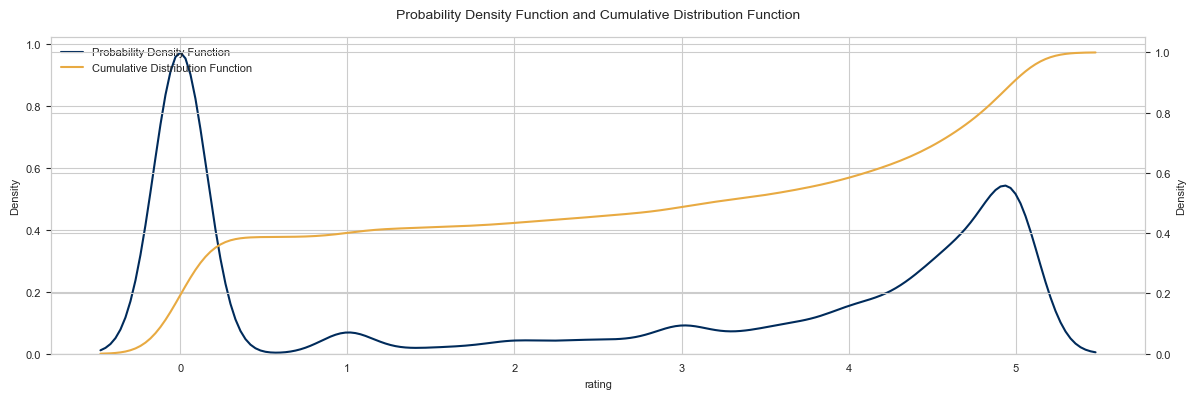

In [9]:
dataset.plot.pdfcdfplot(x='rating', title='Average User Rating Distribution')

 Since the rating scale is in [1,5], its clear that the probability density and histogram above contain apps that have not been rated. To get a sense of the actual ratings, we'll create a new dataset without the non-reviewed apps.

In [10]:
df = dataset.as_df()
df = df.loc[df['rating'] != 0]
rated = AppDataDataset(df=df)

Ok, let's examine the frequency distribution of the ratings.

,count,proportion,cumulative
rating,,,
"(0.995, 2.0]","24,025.00",0.08,0.08
"(2.0, 3.0]","28,283.00",0.10,0.18
"(3.0, 4.0]","44,853.00",0.15,0.33
"(4.0, 5.0]","193,716.00",0.67,1.00
Total,"290,877.00",1.00,


,count,mean,std,min,25%,50%,75%,max
rating,"290,877.00",4.09,1.09,1.00,3.67,4.53,4.98,5.00


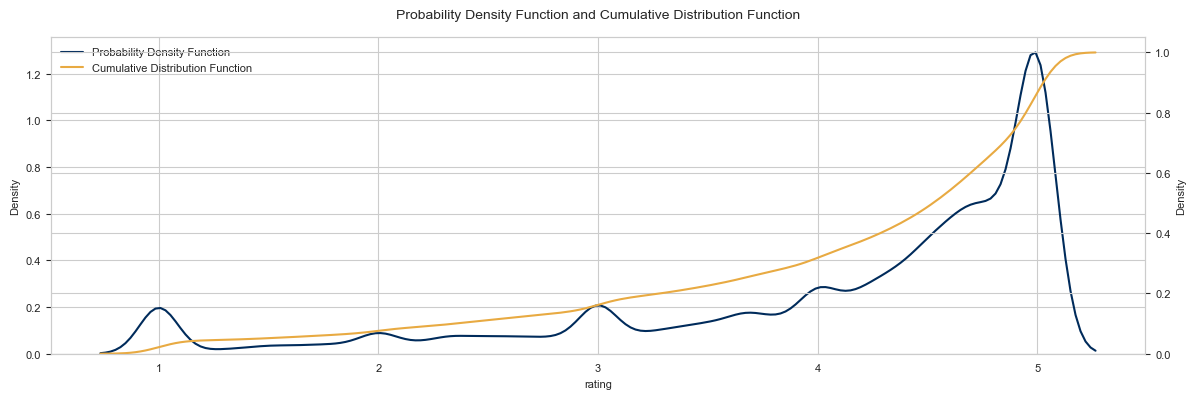

In [11]:
rated.frequency(x='rating', bins=4)
stats = rated.describe(x='rating')
stats.numeric.T
rated.plot.pdfcdfplot(x='rating', bins=4, title='Distribution of User Ratings')


**Key Observations:**
- The long left tail reveals a tendency towards ratings in the 4-5 star range. 
- Five star ratings make up 67% of all ratings. 
- Multiple peaks are also observed at one star and three star ratings and to a lesser degree with two stars. 
- Ratings up to one, two, and three stars, correspond to approximately 8%, 20% and 33% of the cumulative ratings respectively.
- There is no assumption of normality in the distribution of ratings.
- In short, five star ratings dominate customer opinion at this level by a significant margin.
- Note: Taking the average of ordinal values, such as user ratings, is not among the *permissible* statistical transformations whose meanings are preserved when applied to the data, according to measurement theorists, most notably, Harvard psychologist S.S Stevens, who coined the terms *nominal*, *ordinal*, *interval*, and *ratio*. Fortunately, permission is not required in data analysis

#### Rating Count
Rating count can be a harbinger of the intensity of opinion. We'll use the same rated dataset as above. 

In [12]:
stats = rated.describe(x='ratings')
stats.numeric.T


,count,mean,std,min,25%,50%,75%,max
ratings,"290,877.00","4,455.63","135,804.01",1.00,2.00,10.00,73.00,"30,835,421.00"


As indicated by the descriptive statistics (skew), the distribution of rating count is right-skewed, evidenced by the divergence between the two measures of centrality, the median (10 ratings) and the mean (4455 ratings). Let's take a look at the top 10 rated apps.

In [13]:
rated.top_n(x='ratings', n=10)

,id,name,description,category_id,category,price,developer_id,developer,rating,ratings,released,extracted,free,months_avail,ratings_per_month
388004,544007664,"YouTube: Watch, Listen, Stream",Get the official YouTube app on iPhones and iP...,6008,Photo & Video,0.00,281956209,Google LLC,4.68,30835421,2012-09-11 07:23:00,2023-07-31 05:00:00,True,128.00,"240,484.00"
316943,324684580,Spotify - Music and Podcasts,"With the Spotify music and podcast app, you ca...",6011,Music,0.00,324684583,Spotify,4.79,26330932,2011-07-14 11:22:00,2023-07-31 05:00:00,True,142.00,"185,525.00"
388003,389801252,Instagram,Bringing you closer to the people and things y...,6008,Photo & Video,0.00,389801255,"Instagram, Inc.",4.73,24714167,2010-10-06 08:12:00,2023-07-31 05:00:00,True,151.00,"163,675.00"
304061,719972451,DoorDash - Food Delivery,Delivery anywhere you are. DoorDash offers the...,6023,Food & Drink,0.00,719972454,"DoorDash, Inc.",4.77,16175196,2013-10-10 19:46:00,2023-07-31 05:00:00,True,115.00,"140,050.00"
461894,351727428,Venmo,"Venmo is the fast, safe, social way to pay and...",6015,Finance,0.00,351727431,Venmo,4.86,15352766,2010-04-03 05:41:00,2023-07-31 05:00:00,True,157.00,"97,788.90"
388007,835599320,TikTok,TikTok is THE destination for mobile videos. O...,6016,Entertainment,0.00,1322881000,TikTok Ltd.,4.76,14742979,2014-04-02 22:44:00,2023-07-31 05:00:00,True,110.00,"134,174.00"
445511,529379082,Lyft,Get where you’re going with Lyft. Whether you...,6003,Travel,0.00,523004506,"Lyft, Inc.",4.91,12634294,2012-05-31 00:43:00,2023-07-31 05:00:00,True,132.00,"96,038.70"
461891,310633997,WhatsApp Messenger,WhatsApp from Meta is a FREE messaging and vid...,6005,Social Networking,0.00,310634000,WhatsApp Inc.,4.70,11785087,2009-05-04 02:43:00,2023-07-31 05:00:00,True,168.00,"70,242.50"
316944,284035177,Pandora: Music & Podcasts,"Create stations from your favorite songs, arti...",6011,Music,0.00,284035180,"Pandora Media, LLC",4.79,9472664,2019-02-01 08:00:00,2023-07-31 05:00:00,True,53.00,"178,961.00"
265482,431946152,Roblox,Roblox is the ultimate virtual universe that l...,6014,Games,0.00,431946155,Roblox Corporation,4.53,9323618,2011-05-26 20:51:00,2023-07-31 05:00:00,True,143.00,"64,975.30"


YouTube tops the list at over 30m ratings. Let's examine the rating count distribution relative to the percentage of apps.

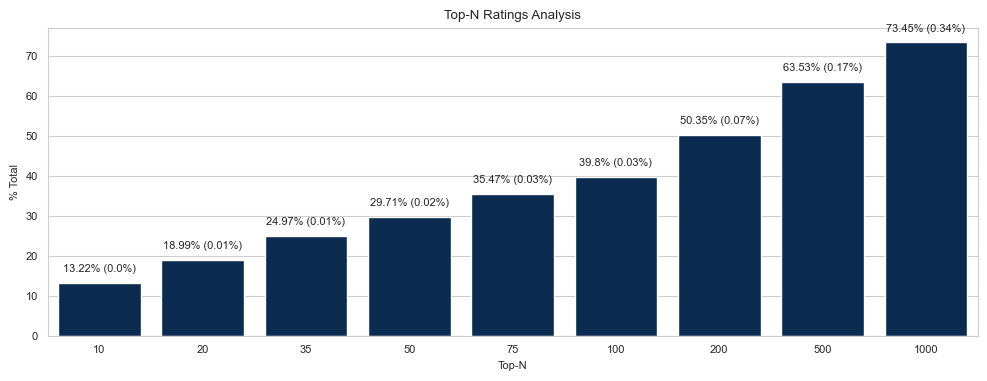

In [14]:
topn = np.array([10,20,35,50,75,100,200,500,1000])
rated.plot.topn_plot(x='ratings', n=topn)

This plot shows the percentage of ratings for the top N rated apps (left percentage) along the x axis, vis-a-vis percentage of apps in the dataset (percentage in parenthesis).

**Key Observations:**
- The distribution of rating counts has a long right tail, with a range from 1 to nearly 31 m ratings. 
- The central tendency is placed at a median of 10 ratings per app. The average is pulled in the direction of the outliers and is about 4.5k ratings.
- Giants of big-tech, social-media, an e-commerce, such as YouTube, Tik-Tok, Spotify, WhatsApp and DoorDash are among the most rated apps in the App Store.
- The top-10 most-rated apps account for nearly 14% of all ratings and less than 1/10th of a percent of all apps. Further, the most-rated 1000 apps, which represent 1/3rd of one percent of all apps, consume nearly 75% of all ratings. 
- Takeaway: Rating counts are vastly disproportionate.
- Note: Apps with earlier release dates may have higher rating counts. Ratings per day since release will remove the temporal dimension from the rating counts. 

#### Price


,count,mean,std,min,25%,50%,75%,max
price,"475,132.00",0.37,5.19,0.00,0.00,0.00,0.00,999.99


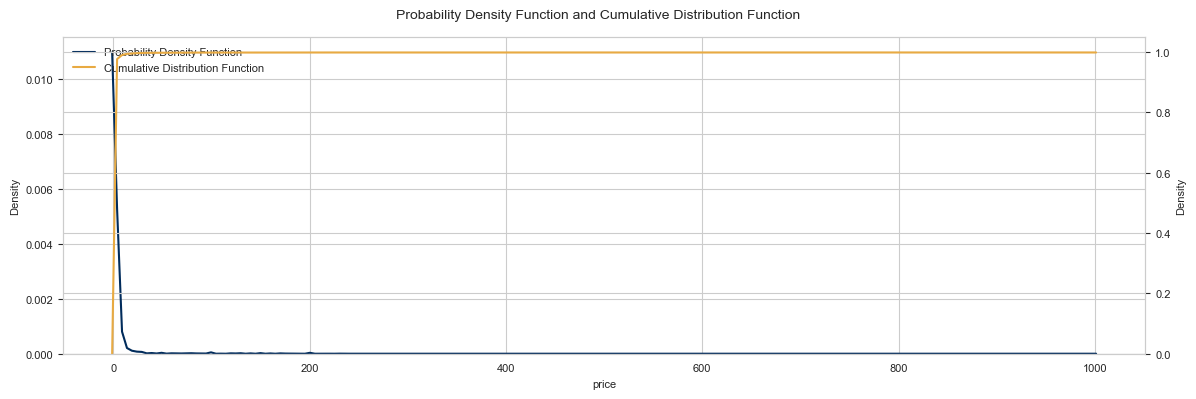

In [15]:
stats = dataset.describe(x='price')
stats.numeric.T
dataset.plot.pdfcdfplot(x='price', title='Price Distribution')

As evidenced above, most apps are free. Let's check the distribution of free vs paid apps.

In [16]:
free = lambda df: df["price"] == 0  
paid = lambda df: df["price"] != 0
free = dataset.subset(condition=free)
paid = dataset.subset(condition=paid)
n_free = free.shape[0]
n_paid = paid.shape[0]
total = n_free + n_paid
p_free = n_free / total * 100
p_paid = n_paid / total * 100
d = {"n": [n_free, n_paid, total], "pct": [p_free, p_paid, 100]}
df = pd.DataFrame(data=d)
df.index = ['Free', 'Paid', 'Total']
df

,n,pct
Free,447478,94.18
Paid,27654,5.82
Total,475132,100.00


As indicated above, 94% of apps in the dataset are free. Let's create a dataset of paid apps and examine the distribution of price.

,count,mean,std,min,25%,50%,75%,max
price,"27,654.00",6.34,20.62,0.29,0.99,2.99,4.99,999.99


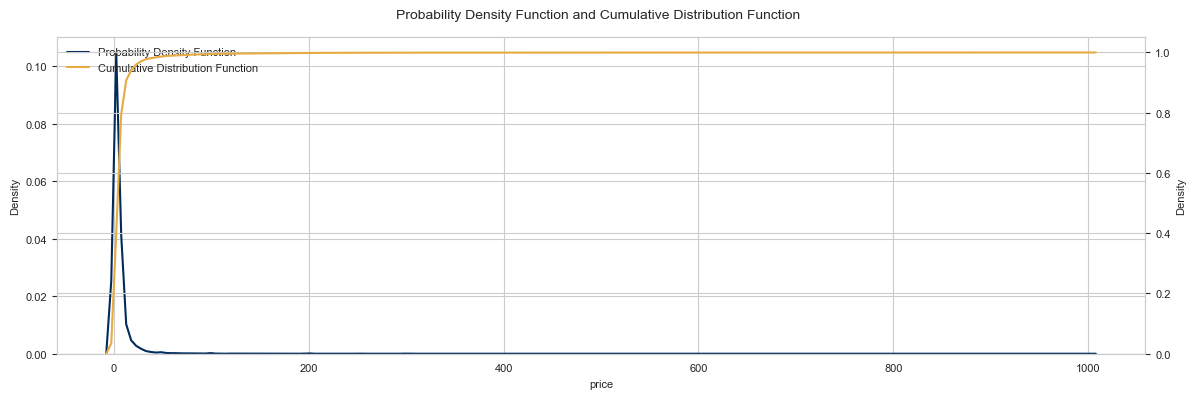

In [17]:
paid_ds = AppDataDataset(df=paid)
stats = paid_ds.describe(x='price')
stats.numeric.T
paid_ds.plot.pdfcdfplot(x='price', title='Price Distribution')

Let's examine the top 10 most expensive apps.

In [18]:
paid_ds.top_n(x='price', n=10)

,id,name,description,category_id,category,price,developer_id,developer,rating,ratings,released,extracted,free,months_avail,ratings_per_month
327301,490451741,CyberTuner,"Reyburn CyberTuner, the pro piano technician’s...",6011,Music,999.99,490451744,"Reyburn Piano Service, Inc.",4.88,49,2012-04-26 04:02:00,2023-07-31 05:00:00,False,133.00,0.37
447527,404643224,Flightview Elite,"Flightview Elite - Real-Time Flight Tracker, F...",6003,Travel,999.99,374341344,FlightView Inc.,3.88,204,2010-11-30 01:11:00,2023-07-31 05:00:00,False,149.00,1.37
77985,403017260,roc.Kasse,stylish cashier system for all purposes place...,6000,Business,999.99,677702973,roc.Kasse GmbH,0.00,0,2011-01-23 13:59:00,2023-07-31 05:00:00,False,147.00,0.00
447201,374341341,Flightview Plus,Flight tracking app from the leaders in real-t...,6003,Travel,999.99,374341344,FlightView Inc.,3.65,110,2010-06-03 16:37:00,2023-07-31 05:00:00,False,155.00,0.71
197835,1099695482,Zomeo - Homeopathy Software,"Hompath Zomeo Mobile App, an innovative Homeop...",6020,Medical,699.99,683742373,Mind Technologies Private Limited,0.00,0,2016-05-06 17:38:00,2023-07-31 05:00:00,False,85.00,0.00
330471,449411468,Verituner,Verituner is an advanced piano tuning app for ...,6011,Music,599.99,449411471,"Veritune, Inc.",5.00,10,2011-08-02 17:10:00,2023-07-31 05:00:00,False,141.00,0.07
397986,1538382779,VidMix Video Transition Maker,Video Editor Transitions - Transitions: classi...,6008,Photo & Video,400.00,1210081138,induben barai,4.28,57,2020-12-13 08:00:00,2023-07-31 05:00:00,False,31.00,1.84
356968,1416864209,AudioToolsMax - Audio Test,AudioToolsMax is the complete professional aud...,6002,Utilities,399.99,291822462,Andrew Smith,4.67,3,2018-08-05 16:46:00,2023-07-31 05:00:00,False,59.00,0.05
284379,386704683,DDS GP,*Rated BEST chair side case presentation softw...,6020,Medical,399.99,386704686,"Kick Your Apps, Inc.",4.25,4,2010-08-23 16:27:00,2023-07-31 05:00:00,False,152.00,0.03
413297,1146089425,SimpleumSafe - Encryption,SimpleumSafe - best next generation encryption...,6007,Productivity,399.99,1081798041,Simpleum Media GmbH,4.40,48,2016-12-19 22:36:00,2023-07-31 05:00:00,False,78.00,0.62


**Key Observations:**
- Of the apps in the dataset, approximately 94% are free, 6% paid.
- Of the paid apps, distribution of price is right-skewed, ranging from $0.29 to $999.99.
- The median for paid apps is about $3 and the 75th percentile of about $5
- A limitation of the dataset is the lack of information regarding in-app purchases.